In [1]:
# Need this for matrix multiplication to work for some reason lol
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
from torchvision.utils import save_image

from classifier import MLPClassifier

import matplotlib.pyplot as plt

import numpy as np

from scipy.linalg import svd, null_space

In [3]:
mlp = torch.load("mlp.model")
mlp

MLPClassifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [4]:
# Get all the weight/bias matrices.
w1 = mlp.fc1.weight.cpu().detach().numpy()
b1 = mlp.fc1.bias.cpu().detach().numpy()
w2 = mlp.fc2.weight.cpu().detach().numpy()
b2 = mlp.fc2.bias.cpu().detach().numpy()
w3 = mlp.fc3.weight.cpu().detach().numpy()
b3 = mlp.fc3.bias.cpu().detach().numpy()

print("Weights shape", w1.shape, w2.shape, w3.shape)
print("Biases shape", b1.shape, b2.shape, b3.shape)

Weights shape (256, 784) (64, 256) (10, 64)
Biases shape (256,) (64,) (10,)


In [269]:
def invert_leaky_relu_(scalar, slope=0.1):
    """
    Inverts a leaky relu transformation
    """
    return scalar if scalar >= 0 else scalar / slope

def leaky_relu_(scalar, slope=0.1):
    return scalar if scalar >= 0 else scalar * slope

# Create the vectorized version of inverse_leaky_relu
invert_leaky_relu = np.vectorize(invert_leaky_relu_)
leaky_relu = np.vectorize(leaky_relu_)

def project(v, space):
    return v #@ space @ space.T # I'm like 90% sure this is the right formula. At least the dimensions line up.

def sample_preimage(W, b, z, n, preimage_dist=None, noise_level=0.1, as_list=False):
    """
    Finds n points x_1, ..., x_n such that W x_i + b = z for all i
    """
    # Subtract b from eq
    new_b = z-b
    # Compute pseudoinverse
    pinv = np.linalg.pinv(W)
    # Get the "central" x which solves the equation (i.e., no null space vectors)
    x_orig = pinv @ new_b
    # Compute the null_space of W
    ns = null_space(W) 
    # Compute some Gaussian noise, and then scale by noise_level
    noise = np.empty((n, ns.shape[1]))
    if preimage_dist is None:
        noise = np.random.randn(n, ns.shape[1]) * noise_level
        # Noise_null_space matrix
        noise_null_mat = noise @ ns.T
    else:
        assert(preimage_dist.shape[1] == x_orig.shape[0])
        x_proj = project(x_orig, ns)
        dist_proj = project(preimage_dist, ns)
        mu = np.mean(dist_proj - x_proj, axis=0)
        cov = np.cov(dist_proj - x_proj, rowvar=False)
        noise_null_mat = np.random.multivariate_normal(mu, cov, size=n)
    # Generate our samples
    new_points = noise_null_mat + x_orig # Since we sampled from the null space of X, these will necessarily be mapped to same latent vector.
    
    # Check that our sampled points are actually correct (up to 1e-3 tolerance)
    #assert (np.linalg.norm(new_points @ W.T + b - z, axis=0) < 1e-3).all()
    
    # Return the original x, as well as the sampled points
    if as_list:
        return x_orig, list(new_points)
    else:
        return x_orig, new_points

def generate_preimage_points(data_dist, h1_dist, h2, w1, w2, b1, b2, n_splits=3):
    
    # Invert leaky relu
    h2 = invert_leaky_relu(h2)
    
    # Generate first set of preimage points
    _, samples1  = sample_preimage(w2, b2, h2, n_splits, preimage_dist=h1_dist)
    
    
    # Invert leaky relu and convert to list
    h1s = list(invert_leaky_relu(samples1))

    # Generate second set of preimage points
    x0 = np.empty((n_splits * n_splits, w1.shape[1]))
    for i, h1 in enumerate(h1s):
        _, x0_single = sample_preimage(w1, b1, h1, n_splits, preimage_dist=data_dist)
        # Fill in our samples
        x0[n_splits*i:n_splits*(i+1)] = x0_single
    
    # We have our preimage points, so we can return.
    return x0.reshape((x0.shape[0], 1, 28, 28))

def generate_preimage_points1(data_dist, h1, w1, b1, n_splits=3):
    # Invert leaky relu
    h1 = invert_leaky_relu(h1)
    # Generate first set of preimage points
    _, x0 = sample_preimage(w1, b1, h1, n_splits, preimage_dist=data_dist)
    
    return x0.reshape((x0.shape[0], 1, 28, 28))

def preprocess_samples(samples):
    to_plot = np.empty((28, 28 * samples.shape[0]))
    for i, sample in enumerate(samples):
        to_plot[:,28 * i: 28 * (i+1)] = sample.reshape(28, 28)
    return np.clip(to_plot, 0, 1)

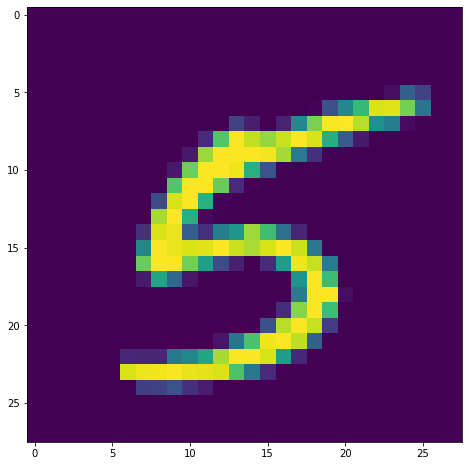

In [282]:
digit = 5
encoded_data = torch.load(f'./digit_data/encoded_data_{digit}.pt')
idx = 4
data_all = encoded_data['data'].detach().numpy()
out_all = encoded_data['out'].detach().numpy()
# target_all = encoded_data['target'].detach()
h1_all = encoded_data['h1'].detach().numpy()
h2_all = encoded_data['h2'].detach().numpy()
data = data_all[idx]
plt.imshow(data.reshape(28, 28))
out = out_all[idx]
# target = target_all[idx]
h1 = h1_all[idx]
h2 = h2_all[idx]
x_inv1 = np.clip(generate_preimage_points1(data_all, h1, w1, b1, n_splits=8), 0, 1)
x_inv2 = np.clip(generate_preimage_points(data_all, h1_all, h2, w1, w2, b1, b2, n_splits=8), 0, 1)

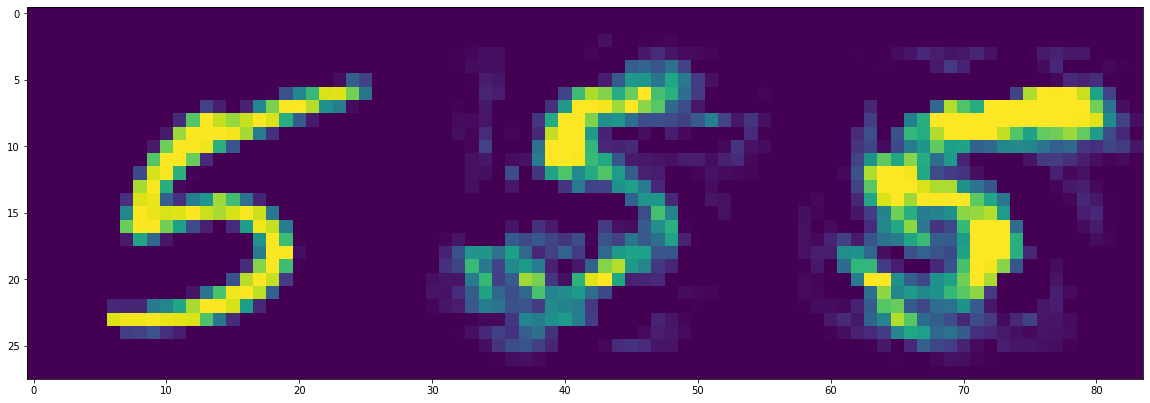

In [283]:
x_inv1_tp = x_inv1[0][0]
x_inv2_tp = x_inv2[0][0]
data_tp = data.reshape(x_inv1_tp.shape)
to_plot = np.empty((x_inv1_tp.shape[0], x_inv1_tp.shape[1] * 3))
to_plot[:,:28] = data_tp
to_plot[:,28:56] = x_inv1_tp
to_plot[:,56:] = x_inv2_tp
plt.imshow(to_plot)

save_image(torch.tensor(x_inv1), f'./mnist_inversions/inverted_mlp_output_h1_{digit}.png')
save_image(torch.tensor(x_inv2), f'./mnist_inversions/inverted_mlp_output_h2_{digit}.png')

(9, 784)


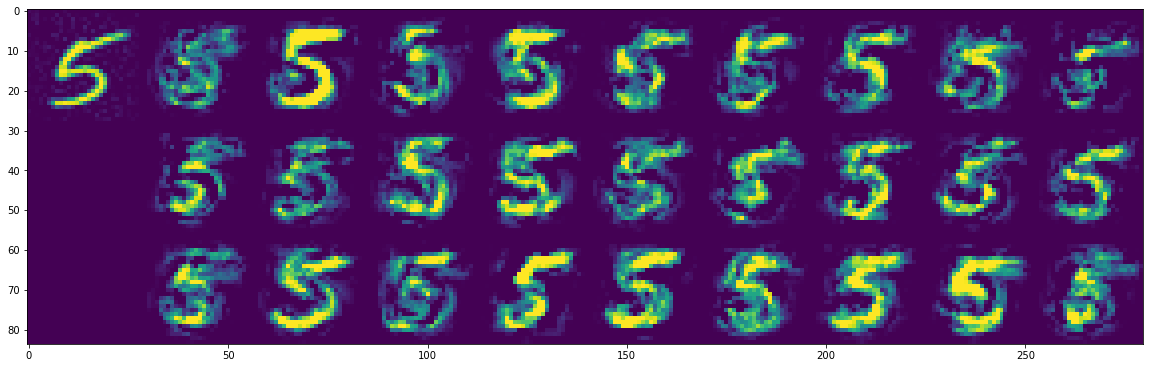

In [284]:
plt.rcParams["figure.figsize"] = (20,8)
n_samples = 9
n_splits = 3
to_plot_2 = np.zeros((28 * 3, (1 + n_samples) * 28))
h1_orig, h1_sample = sample_preimage(w2, b2, invert_leaky_relu(h2), n_samples, preimage_dist=h1_all)
# Original h1 inversion
x_orig1, x_sample1 = sample_preimage(w1, b1, invert_leaky_relu(h1), n_samples, preimage_dist=data_all)
# Unsampled h1 inversion
x_orig2, x_sample2 = sample_preimage(w1, b1, invert_leaky_relu(h1_orig), n_samples, preimage_dist=data_all)

x_sample3 = np.empty((n_samples, 784))
for i in range(n_samples):
    # Sampled h1 inversion
    x_orig3, x_s3 = sample_preimage(w1, b1, invert_leaky_relu(h1_sample[i]), 1, preimage_dist=data_all)
    x_sample3[i] = x_orig3
    x_sample3[i] = x_s3[0]

to_plot_2[:28,:28] = np.clip(x_orig1.reshape(28, 28), 0, 1)
#to_plot_2[28:-28, :28] = np.clip(x_orig2.reshape(28, 28), 0, 1)
#to_plot_2[-28:, :28] = np.clip(x_orig3.reshape(28, 28), 0, 1)

print(x_sample1.shape)
to_plot_2[:28,28:] = preprocess_samples(x_sample1)
to_plot_2[28:-28, 28:] = preprocess_samples(x_sample2)
to_plot_2[-28:, 28:] = preprocess_samples(x_sample3)
    
plt.imshow(to_plot_2) 

In [285]:
x_orig, x_samples = sample_preimage(w1, b1, invert_leaky_relu(h1), 5, preimage_dist=data_all, noise_level=0.1)

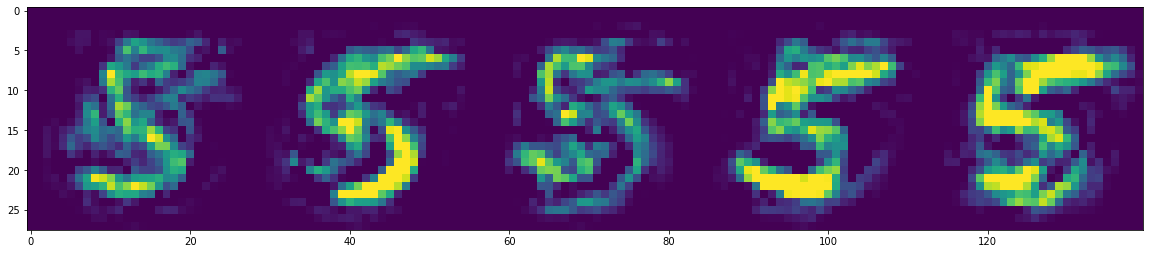

In [286]:
to_plot = preprocess_samples(x_samples)
plt.imshow(to_plot)

In [200]:
x_samples.shape

(5, 784)

In [179]:
data_all.shape

(128, 784)

In [197]:
np.empty((x_samples.shape[0], np.prod(())).shape

(5, 784)